In [5]:
pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
BATCH_SIZE = 256

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='mnist', train=True, transform=transoforms, download=False)
test_dataset = tv.datasets.EMNIST('.', split='mnist', train=False, transform=transoforms, download=False)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [4]:
train_dataset.data.shape, test_dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [5]:
train_dataset.targets, test_dataset.targets

(tensor([4, 1, 4,  ..., 1, 5, 0]), tensor([1, 8, 6,  ..., 8, 9, 6]))

In [6]:
train_dataset.class_to_idx 

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [7]:
train_dataset.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
num_classes = len(train_dataset.classes)
num_classes

10

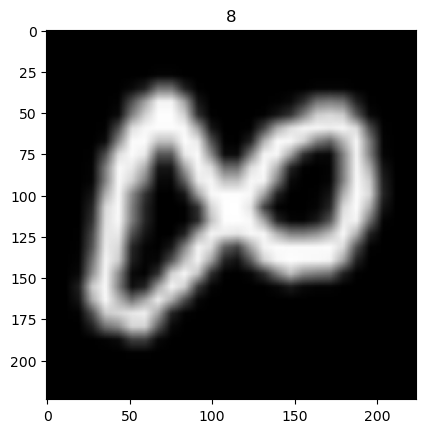

In [9]:
index = 999
img = train_dataset[index][0]
plt.imshow(img[0], cmap='gray');
plt.title(train_dataset[index][1])
plt.show()

In [10]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [11]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

# resnet18

In [13]:
model = tv.models.resnet18(weights=None)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
summary(model.to(device), input_size=(3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [42]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [43]:
model.fc = nn.Linear(in_features=512, out_features=num_classes)

In [44]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [47]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [48]:
train(model, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 1.531. Train acc: 0.957. Train Loss: 0.141
Step 100. time since epoch: 141.713. Train acc: 0.897. Train Loss: 0.492
Step 200. time since epoch: 286.987. Train acc: 0.937. Train Loss: 0.288
--------------------
epoch 1, loss 0.2547, train acc 0.944, test acc 0.984, time 356.9 sec
Step 0. time since epoch: 1.298. Train acc: 0.988. Train Loss: 0.050
Step 100. time since epoch: 136.691. Train acc: 0.289. Train Loss: 5.311
Step 200. time since epoch: 272.179. Train acc: 0.540. Train Loss: 3.006
--------------------
epoch 2, loss 2.6238, train acc 0.592, test acc 0.912, time 341.5 sec
Step 0. time since epoch: 1.481. Train acc: 0.898. Train Loss: 0.364
Step 100. time since epoch: 135.880. Train acc: 0.934. Train Loss: 0.224
Step 200. time since epoch: 266.490. Train acc: 0.943. Train Loss: 0.192
--------------------
epoch 3, loss 0.1842, train acc 0.946, test acc 0.961, time 328.9 sec
Step 0. time since epoch: 1.255. Train acc: 0.953. Train Loss: 0.159
Step 100. tim

# VGG 16

In [12]:
model_vgg = tv.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# Убираем требование градиента:
for param in model_vgg.parameters():
    param.requires_grad = False

In [14]:
model_vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
model_vgg.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=4096, out_features=1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=1024, out_features=num_classes)
)   

In [23]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
print("Params to learn:")
params_to_update = []
for name, param in model_vgg.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [25]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [26]:
BATCH_SIZE = 64

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='mnist', train=True, transform=transoforms, download=False)
test_dataset = tv.datasets.EMNIST('.', split='mnist', train=False, transform=transoforms, download=False)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [27]:
torch.cuda.empty_cache()
torch.cuda.max_memory_allocated()

5870326784

In [28]:
train(model_vgg, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 0.645. Train acc: 0.078. Train Loss: 2.301
Step 100. time since epoch: 308.210. Train acc: 0.784. Train Loss: 6.749
Step 200. time since epoch: 617.241. Train acc: 0.824. Train Loss: 4.085
Step 300. time since epoch: 924.740. Train acc: 0.827. Train Loss: 3.242
Step 400. time since epoch: 1234.170. Train acc: 0.820. Train Loss: 2.714
Step 500. time since epoch: 1542.077. Train acc: 0.811. Train Loss: 2.381
Step 600. time since epoch: 1854.526. Train acc: 0.806. Train Loss: 2.139
Step 700. time since epoch: 2206.566. Train acc: 0.800. Train Loss: 1.986
Step 800. time since epoch: 2549.599. Train acc: 0.792. Train Loss: 1.886
Step 900. time since epoch: 2877.961. Train acc: 0.779. Train Loss: 1.827
--------------------
epoch 1, loss 1.7975, train acc 0.776, test acc 0.878, time 3500.5 sec
Step 0. time since epoch: 3.065. Train acc: 0.844. Train Loss: 0.449
Step 100. time since epoch: 374.404. Train acc: 0.958. Train Loss: 0.197
Step 200. time since epoch: 809.95

KeyboardInterrupt: 

# Inception v3

In [12]:
model_inc = tv.models.inception_v3(weights=None)
model_inc

C:\Users\Admin\anaconda3\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [13]:
model_inc.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [14]:
model_inc.AuxLogits.fc

Linear(in_features=768, out_features=1000, bias=True)

In [15]:
model_inc.fc = nn.Linear(in_features=2048, out_features=num_classes)
model_inc

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [16]:
print("Params to learn:")
params_to_update = []
for name, param in model_inc.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.b

In [17]:
BATCH_SIZE = 128

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='mnist', train=True, transform=transoforms, download=False)
test_dataset = tv.datasets.EMNIST('.', split='mnist', train=False, transform=transoforms, download=False)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [18]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [19]:
# summary(model_inc, input_size=(3,299,299))

In [30]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat, *_ = net(X) # unpuck InceptionOutputs
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [21]:
train(model_inc, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 28.235. Train acc: 0.078. Train Loss: 2.429
Step 100. time since epoch: 3566.647. Train acc: 0.671. Train Loss: 1.022
Step 200. time since epoch: 5216.487. Train acc: 0.808. Train Loss: 0.610


KeyboardInterrupt: 

# DenseNet 161

In [12]:
model_dnet = tv.models.densenet161(pretrained=True)
model_dnet

C:\Users\Admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [13]:
# Убираем требование градиента:
for param in model_dnet.parameters():
    param.requires_grad = False

In [14]:
model_dnet.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [15]:
model_dnet.classifier = nn.Linear(in_features=2208, out_features=num_classes)

In [16]:
print("Params to learn:")
params_to_update = []
for name, param in model_dnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [17]:
BATCH_SIZE = 32

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', split='mnist', train=True, transform=transoforms, download=False)
test_dataset = tv.datasets.EMNIST('.', split='mnist', train=False, transform=transoforms, download=False)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [18]:
torch.cuda.empty_cache()
torch.cuda.max_memory_allocated()

0

In [19]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [20]:
trainer = torch.optim.Adam(params_to_update, lr=0.01)

In [21]:
train(model_dnet, train_iter, test_iter, trainer, 10)

Step 0. time since epoch: 3.224. Train acc: 0.062. Train Loss: 2.401
Step 100. time since epoch: 38.526. Train acc: 0.670. Train Loss: 1.243
Step 200. time since epoch: 73.407. Train acc: 0.760. Train Loss: 0.856
Step 300. time since epoch: 107.744. Train acc: 0.803. Train Loss: 0.684
Step 400. time since epoch: 142.238. Train acc: 0.825. Train Loss: 0.601
Step 500. time since epoch: 177.057. Train acc: 0.834. Train Loss: 0.570
Step 600. time since epoch: 211.905. Train acc: 0.843. Train Loss: 0.534
Step 700. time since epoch: 246.386. Train acc: 0.852. Train Loss: 0.501
Step 800. time since epoch: 281.080. Train acc: 0.857. Train Loss: 0.488
Step 900. time since epoch: 316.017. Train acc: 0.862. Train Loss: 0.471
Step 1000. time since epoch: 350.679. Train acc: 0.866. Train Loss: 0.455
Step 1100. time since epoch: 385.255. Train acc: 0.872. Train Loss: 0.436
Step 1200. time since epoch: 419.889. Train acc: 0.876. Train Loss: 0.423
Step 1300. time since epoch: 454.718. Train acc: 0.880

Step 1100. time since epoch: 366.484. Train acc: 0.959. Train Loss: 0.242
Step 1200. time since epoch: 400.209. Train acc: 0.960. Train Loss: 0.237
Step 1300. time since epoch: 434.417. Train acc: 0.960. Train Loss: 0.232
Step 1400. time since epoch: 468.419. Train acc: 0.960. Train Loss: 0.235
Step 1500. time since epoch: 501.548. Train acc: 0.961. Train Loss: 0.234
Step 1600. time since epoch: 534.314. Train acc: 0.960. Train Loss: 0.238
Step 1700. time since epoch: 567.474. Train acc: 0.960. Train Loss: 0.237
Step 1800. time since epoch: 600.844. Train acc: 0.960. Train Loss: 0.240
--------------------
epoch 6, loss 0.2392, train acc 0.960, test acc 0.951, time 711.4 sec
Step 0. time since epoch: 0.332. Train acc: 1.000. Train Loss: 0.016
Step 100. time since epoch: 33.412. Train acc: 0.966. Train Loss: 0.203
Step 200. time since epoch: 66.165. Train acc: 0.963. Train Loss: 0.201
Step 300. time since epoch: 99.247. Train acc: 0.963. Train Loss: 0.202
Step 400. time since epoch: 132.

In [28]:
pd.DataFrame(
    {'resnet_18': [0.990], 'vgg16': [0.989], 'inception_v3': [0.808], 'densenet161': [0.964]},
    index = ['test_acc']
)

,resnet_18,vgg16,inception_v3,densenet161
test_acc,0.99,0.989,0.808,0.964
